In [1]:
import os
import glob
import numpy as np
import pandas as pd
import requests
import time
from datetime import datetime, date, time, timedelta

#for models
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neighbors import KNeighborsRegressor

#for PCA & PLS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

#for Data
import yfinance as yf

#for Data Distribution
from scipy.stats import kurtosis, skew, shapiro

# for visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.graph_objects as go
import seaborn as sns


In [2]:
# Fetch historical data for the S&P 500
sp500_data = yf.download('^GSPC', start='2002-01-01', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed


In [3]:
print(sp500_data.head())
print(len(sp500_data)) # Print the first few rows of the data

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2002-01-02  1148.079956  1154.670044  1136.229980  1154.670044  1154.670044   
2002-01-03  1154.670044  1165.270020  1154.010010  1165.270020  1165.270020   
2002-01-04  1165.270020  1176.550049  1163.420044  1172.510010  1172.510010   
2002-01-07  1172.510010  1176.969971  1163.550049  1164.890015  1164.890015   
2002-01-08  1164.890015  1167.599976  1157.459961  1160.709961  1160.709961   

                Volume  
Date                    
2002-01-02  1171000000  
2002-01-03  1398900000  
2002-01-04  1513000000  
2002-01-07  1308300000  
2002-01-08  1258800000  
5537


In [4]:
#Simple Moving Average:
#returns the dataframe with additional coumn of simple moving average
def calculate_sma(df: pd.DataFrame, column: str = 'Adj Close', window_size: int = 15) -> pd.DataFrame:
    """
    Calculate the Simple Moving Average (SMA) for a given column in a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the financial data.
        column (str): Name of the column for which to calculate SMA. Default is 'close'.
        window_size (int): Size of the moving window. Default is 15.

    Returns:
        pd.DataFrame: DataFrame with SMA column added.
    """
    # Calculate SMA
    sma = df[column].rolling(window=window_size, min_periods=1).mean()
    
    # Create a DataFrame to store SMA
    df['SMA'] = sma
    df['SMA_signal'] = df['Close'] - df['SMA']
    return df

In [5]:
#Weighted Moving Average
def calculate_wma(df: pd.DataFrame, column: str = 'Adj Close', window_size: int = 15) -> pd.DataFrame:
    """
    Calculate the Weighted Moving Average (WMA) for a given column in a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the financial data.
        column (str): Name of the column for which to calculate WMA. Default is 'close'.
        window_size (int): Size of the moving window. Default is 15.

    Returns:
        pd.DataFrame: DataFrame with WMA and WMA signal columns added.
    """
    # Generate the weights
    weights = np.arange(1, window_size + 1)
    data = df[column]
    
    # Calculate the WMA using convolution
    wma = data.rolling(window=window_size).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    
    # Create a DataFrame to store WMA
    df['WMA'] = wma
    
    # Add WMA signal column
    df['WMA_signal'] = df[column] - wma

    
    return df

In [6]:
#MACD
def calculate_macd(df: pd.DataFrame, short_window:int=12, long_window:int=26, signal_window:int=9, column: str = 'Adj Close') -> pd.DataFrame:
    """
    Calculate the Moving Average Convergence Divergence (MACD) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        short_window (int): The short-term window size for the short EMA.
        long_window (int): The long-term window size for the long EMA.
        signal_window (int): The window size for the signal line EMA.

    Returns:
        DataFrame: DataFrame with additional columns for MACD and signal line.
    """
    # Calculate short-term EMA
    short_ema = df[column].ewm(span=short_window, min_periods=1, adjust=False).mean()
    
    # Calculate long-term EMA
    long_ema = df[column].ewm(span=long_window, min_periods=1, adjust=False).mean()
    
    # Calculate MACD line
    macd_line = short_ema - long_ema
    
    # Calculate signal line
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    
    # Store MACD and signal line in the DataFrame
    df['MACD'] = macd_line
    df['Signal Line'] = signal_line
    df['macd_signal'] = macd_line - signal_line
    return df

In [7]:
#Stochastic_oscillator
def calculate_stochastic_oscillator(df, k_fast_period=14, k_slow_period=3, d_slow_period=3, column: str = 'Adj Close'):
    """
    Calculate the Stochastic Oscillator and its corresponding moving averages (K and D lines).

    Parameters:
        df (DataFrame): DataFrame containing the data.
        k_fast_period (int): The period for the fast %K line.
        k_slow_period (int): The period for the slow %K line.
        d_slow_period (int): The period for the slow %D line.

    Returns:
        DataFrame: DataFrame with additional columns for %K_fast, %K_slow, %D_fast, and %D_slow.
    """
    # Calculate highest high and lowest low over the period
    HH = df['High'].rolling(window=k_fast_period).max()
    LL = df['Low'].rolling(window=k_fast_period).min()

    # Calculate %K_fast
    df['%K_fast'] = ((df[column] - LL) / 
                     (HH - LL)) * 100
    
    # Calculate %K_slow (smoothed %K_fast)
    df['%K_slow'] = df['%K_fast'].rolling(window=k_slow_period).mean()
    
    # Calculate %D_fast (3-day SMA of %K_slow)
    df['%D_fast'] = df['%K_slow'].rolling(window=d_slow_period).mean()
    
    # Calculate %D_slow (3-day SMA of %D_fast)
    df['%D_slow'] = df['%D_fast'].rolling(window=d_slow_period).mean()
    
    return df

In [8]:
#RSI
def calculate_rsi(df, window_size=14, column: str = 'Adj Close'):
    """
    Calculate the Relative Strength Index (RSI) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for calculating RSI.

    Returns:
        DataFrame: DataFrame with an additional column for RSI.
    """
    # Calculate price changes
    delta = df[column].diff()
    
    # Define up and down moves
    gain = (delta.where(delta > 0, 0)).rolling(window=window_size).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window_size).mean()
    
    # Calculate the relative strength (RS)
    rs = gain / loss
    
    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    
    # Store RSI in the DataFrame
    df['RSI'] = rsi
    
    return df

In [9]:
#WPR
def calculate_williams_percent_r(df, window=14, column: str = 'Adj Close'):
    """
    Calculate the Williams %R (WPR) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for calculating WPR.

    Returns:
        DataFrame: DataFrame with an additional column for WPR.
    """
    # Calculate highest high and lowest low over the window
    highest_high = df['High'].rolling(window=window).max()
    lowest_low = df['Low'].rolling(window=window).min()
    
    # Calculate Williams %R
    wpr = ((highest_high - df[column]) / (highest_high - lowest_low)) * -100
    
    # Store WPR in the DataFrame
    df['WPR'] = wpr
    
    return df

In [10]:
#Bollinger Bands
def calculate_bollinger_bands(df, window=20, num_std_dev=2, column: str = 'Adj Close'):
    """
    Calculate Bollinger Bands for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for the moving average.
        num_std_dev (int): The number of standard deviations for the bands.

    Returns:
        DataFrame: DataFrame with additional columns for Bollinger Bands.
    """
    # Calculate rolling mean and standard deviation
    rolling_mean = df[column].rolling(window=window).mean()
    rolling_std = df[column].rolling(window=window).std()
    
    # Calculate upper and lower bands
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    
    # Store Bollinger Bands in the DataFrame
    df['Bollinger Upper'] = upper_band
    df['Bollinger Lower'] = lower_band
    df['Bollinger Diff'] = upper_band - lower_band
    
    return df

In [11]:
#On-Balance Volume (OBV)
def calculate_obv(df, column: str = 'Adj Close'):
    """
    Calculate On-Balance Volume (OBV) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.

    Returns:
        DataFrame: DataFrame with additional column for OBV.
    """
    obv_values = []
    prev_obv = 0

    for i in range(1, len(df)):
        if df[column].iloc[i] > df[column].iloc[i - 1]:
            obv = prev_obv + df['Volume'].iloc[i]
        elif df[column].iloc[i] < df[column].iloc[i - 1]:
            obv = prev_obv - df['Volume'].iloc[i]
        else:
            obv = prev_obv

        obv_values.append(obv)
        prev_obv = obv

    # Add initial OBV value as 0
    obv_values = [0] + obv_values

    # Store OBV in the DataFrame
    df['OBV'] = obv_values

    return df

In [12]:
#Average True Range (ATR)
def calculate_atr(df, period=14):
    """
    Calculate the Average True Range (ATR) of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'High', 'Low', and 'Close' columns representing high, low, and closing prices respectively.
        period (int): Number of periods for which to calculate the ATR (default is 14).

    Returns:
        DataFrame: DataFrame with 'ATR' column containing the calculated ATR values.
    """
    high = df['High']
    low = df['Low']
    close = df['Adj Close']
    
    # True Range (TR) calculation
    df['TR'] = df[['High', 'Low', 'Adj Close']].apply(lambda row: max(row['High'] - row['Low'], abs(row['High'] - row['Adj Close']), abs(row['Low'] - row['Adj Close'])), axis=1)
    
    # ATR calculation
    df['ATR'] = df['TR'].rolling(period).mean()
    
    # Drop the TR column if not needed
    df.drop('TR', axis=1, inplace=True)
    
    return df

In [13]:
#rice Rate of Change (ROC)
def calculate_roc(df, n_periods=12, column='Adj Close'):
    """
    Calculate the Price Rate of Change (ROC) of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'Adj Close' column representing closing prices.
        n_periods (int): Number of periods for which to calculate the ROC. # It can be anything such as 12, 25,
        or 200. Short-term trader traders typically use a smaller number while longer-term investors use a larger
        number.

    Returns:
        DataFrame: DataFrame with 'ROC' column containing the calculated ROC values.
    """
    close_prices = df[column]
    close_prices_shifted = close_prices.shift(n_periods)
    
    roc = ((close_prices - close_prices_shifted) / close_prices_shifted) * 100
    
    df['ROC'] = roc
    return df

In [14]:
#Money Flow Index - MFI
def calculate_mfi(df, period=14):
    """
    Calculate the Money Flow Index (MFI) of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'High', 'Low', 'Close', and 'Volume' columns representing high, low, closing prices, and volume respectively.
        period (int): Number of periods for which to calculate the MFI (default is 14).

    Returns:
        DataFrame: DataFrame with 'MFI' column containing the calculated MFI values.
    """
    high = df['High']
    low = df['Low']
    close = df['Adj Close']
    volume = df['Volume']
    
    # Typical Price calculation
    tp = (high + low + close) / 3
    
    # Raw Money Flow calculation
    mf = tp * volume
    
    # Determine whether the typical price is higher or lower than the previous period
    tp_shifted = tp.shift(1)
    positive_flow = (tp > tp_shifted)
    negative_flow = (tp < tp_shifted)
    
    # Calculate positive and negative money flow
    positive_mf = positive_flow * mf
    negative_mf = negative_flow * mf
    
    # Calculate the Money Flow Ratio (MFR)
    mfr = positive_mf.rolling(window=period).sum() / negative_mf.rolling(window=period).sum()
    
    # Calculate the Money Flow Index (MFI)
    mfi = 100 - (100 / (1 + mfr))
    
    df['MFI'] = mfi
    
    return df

In [15]:
def calculate_chaikin_oscillator(df, short_period=3, long_period=10):
    """
    Calculate the Chaikin Oscillator of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'High', 'Low', 'Adj Close', and 'Volume' columns representing high, low, closing prices, and volume respectively.
        short_period (int): Number of periods for the short EMA (default is 3).
        long_period (int): Number of periods for the long EMA (default is 10).

    Returns:
        DataFrame: DataFrame with 'Chaikin_Oscillator' column containing the calculated Chaikin Oscillator values.
    """
    high = df['High']
    low = df['Low']
    close = df['Adj Close']
    volume = df['Volume']
    
    # Money Flow Multiplier calculation
    mfm = ((close - low) - (high - close)) / (high - low)
    
    # Money Flow Volume calculation
    mfv = mfm * volume
    
    # Accumulation/Distribution Line (ADL) calculation
    adl = mfv.cumsum()
    
    # Calculate the EMA for ADL
    ema_short = adl.ewm(span=short_period, min_periods=short_period, adjust=False).mean()
    ema_long = adl.ewm(span=long_period, min_periods=long_period, adjust=False).mean()
    
    # Calculate the Chaikin Oscillator
    chaikin_oscillator = ema_short - ema_long
    
    df['Chaikin_Oscillator'] = chaikin_oscillator
    
    return df

In [16]:
#Bulid the technical indicators: features
def technical_indicators(df):
    df = calculate_sma(df)
    df = calculate_wma(df)
    df = calculate_macd(df)
    df = calculate_rsi(df)
    df = calculate_stochastic_oscillator(df)
    df = calculate_bollinger_bands(df)
    df = calculate_williams_percent_r(df)
    df = calculate_obv(df)
    df = calculate_roc(df)
    df = calculate_atr(df)
    df = calculate_mfi(df)
    df = calculate_chaikin_oscillator(df)
    return df 

In [17]:
# All analyzed technical indicators are lagged by one period before being used as predictors for returns in the models in order to avoid the so-called look ahead 
# bias involving making decisions in the same period for which the given signal was generated.
def lag_technical_indicators(df):
    """
    Lag all columns in a DataFrame by one period.

    Parameters:
        df (DataFrame): DataFrame containing the calculated technical indicators.

    Returns:
        DataFrame: DataFrame with all columns lagged by one period.
    """
    # Lag all columns by one period
    df_lagged = df.shift(-20)
    
    return df_lagged

In [18]:
# Transformation Function
# Technical analysis indicators need to be rescaled before being fed to the models.
# The process is conducted using a version of min-max normalization technique which produces outputs in range from ‐1 to 1.
# This technique was chosen for two reasons: it is intuitive as the machine learning models produce output 
# variable that is also ranging from ‐1 to 1 and because it causes the input data to be more comparable. 
# X'(t) = (X(t) - min(x)) / (max(x) - min(x))*2 -1

def feature_transform(df):
    """
    Transform all columns in the DataFrame as the following formula
    X'(t) = (X(t) - min(x)) / (max(x) - min(x))*2 -1

    Parameters:
        df (DataFrame): DataFrame containing the calculated technical indicators.

    Returns:
        DataFrame: DataFrame with all columns transformed.
    """
    max_x = df.max()
    min_x = df.min()

    df_transformed = (df - min_x) / (max_x - min_x) * 2 - 1

    return df_transformed

In [19]:
#Log_return:
def calculate_log_return(df, column='Adj Close'):
    """
    Calculate log returns from adjusted close prices.

    Parameters:
        df (DataFrame): DataFrame containing adjusted close prices.
        column (str): Name of the column containing adjusted close prices.

    Returns:
        DataFrame: DataFrame containing log returns.
    """
    # Shift adjusted close prices by one day to get t-1 prices
    previous_adj_close = df[column].shift(1)
    
    # Calculate log returns
    log_returns = np.log(df[column] / previous_adj_close)
    # Concatenate log returns with the original DataFrame
    df['log_return'] = log_returns  
    
    return df

In [20]:
def calculate_log_returns_per(df, column='Adj Close'):
    """
    Calculate logarithmic returns for adjusted closing prices.
    
    Parameters:
        df (DataFrame): DataFrame containing adjusted closing prices.
        column_name (str): Name of the column containing adjusted closing prices.
        
    Returns:
        log_returns (Series): Series containing logarithmic returns.
    """
    # Calculate the percentage change in adjusted closing prices
    returns = df[column].pct_change()
    
    # Calculate logarithmic returns
    log_returns = np.log(1 + returns)
    df['log_return_per'] = log_returns  

    return df

In [21]:
def calculate_discrete_returns(df, column='Adj Close'):
    """
    Calculate discrete returns for a given column in a DataFrame.
    
    Parameters:
        df (DataFrame): DataFrame containing the data.
        column_name (str): Name of the column for which to calculate discrete returns.
        
    Returns:
        discrete_returns (Series): Series containing discrete returns.
    """
    # Calculate the difference between consecutive values
    differences = df[column].diff()
    
    # Calculate discrete returns
    discrete_returns = differences / df[column].shift(1)
    df['discrete_return'] = discrete_returns  
    
    return df

In [22]:
#truncate the dataframe from the biggining so the walk forward splits will continue untill the last date
def truncate_before_wf(df, in_sample_size, out_sample_size):
    drop_index = (len(df) - in_sample_size) % out_sample_size
    return (df.iloc[drop_index:, :])

In [23]:
# Research employed dynamic estimation windows which means that the underlying parameters of the models 
# were periodically recalibrated to reflect current market behaviors. Observations from the beginning 
# of the available period were initially trimmed in order for the overall number of observations for
# each index to be easily divisible into equal subsets. Calibration of models’ parameters was conducted 
# on 200 trading day window (in-sample) and then model predictions were applied onto next 20 trading day
# window (out-of-sample). For each subsequent dynamic window iteration, in-sample and out-of-sample moved 
# by 20 trading days. 

def walk_forward_validation(df, in_sample_size, out_sample_size):
    """
    Perform walk-forward validation on a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        in_sample_size (int): Number of periods to use for in-sample data.
        out_sample_size (int): Number of periods to use for out-of-sample data.

    Returns:
        Tuple: Tuple containing lists of in-sample and out-of-sample data.
    """
    total_rows = len(df)
    n_subsets = (total_rows - in_sample_size) // out_sample_size
    splits = []
        
    for i in range(n_subsets):
        start_index = i * out_sample_size
        end_index = start_index + in_sample_size + out_sample_size
        
        if end_index > total_rows:
            break
        
        in_sample = df.iloc[start_index : start_index + in_sample_size]
        out_of_sample = df.iloc[start_index + in_sample_size : end_index]
        
        splits.append((in_sample, out_of_sample))
    return (splits)

In [24]:
# Compute the correlation coefficients between each feature and the return & print it

def correlation(df, target_name):

    correlation_with_target = np.abs(df.corrwith(df[target_name]))

    # Display the correlation coefficients
    print("Correlation with Log return:")
    print(correlation_with_target.sort_values(ascending=False))
    correlation_with_target.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation', )

In [25]:
#Thus far, we've only used a simple correlation statistic across the full time period. 
#This is a good place to start but, is a dangerous place to stop. Financial time series data suffers
# from non-stationarity and regime change, so a relationship which on average has existed may have been 
#wildly unstable over time.

#To check, we'll plot the rolling correlation of these selected features.

# Compute the rolling correlation for each pair of selected features
def rolling_correlation(df, target_name, window_size = 200):

    correlation_with_target_200 = df.rolling(window=window_size).corr(df[target_name])
    # Create traces for each feature
    traces = []
    for feature in df.columns:
        trace = go.Scatter(
            x=correlation_with_target_200.index,
            y=correlation_with_target_200[feature],
            mode='lines',
            name=feature
        )
        traces.append(trace)

    # Create layout for the plot
        layout = go.Layout(
        title='Rolling Correlation of Features with Log Return',
        xaxis=dict(title='Index'),
        yaxis=dict(title='Rolling Correlation with Log Return'),
        hovermode='closest',
        autosize=True
    )

    # Create figure object
    fig = go.Figure(data=traces, layout=layout)

    # Show plot
    fig.show()

In [26]:
def features_paiplot(df):
    pairplot = sns.pairplot(df, height=1.5)

    # Set the title
    pairplot.figure.suptitle('Pairplot of features', y=1.02)

    # Show the plot
    plt.show()

In [27]:
#Truncate NaN Data
def drop_NAN(df):
    # Remove rows with NaN values
    cleaned_df = df.dropna()

    return cleaned_df

In [28]:
#check distribution 
def check_distribution(df, column_name='Adj Close'):
    """
    Check the distribution of a column in a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        column_name (str): Name of the column to check the distribution for (default is 'Adj Close').

    Returns:
        None (displays descriptive statistics and visualizations)
    """
    # Descriptive statistics
    print("Descriptive Statistics:")
    print(df[column_name].describe())

    # Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column_name], kde=True)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

In [29]:
def check_distribution_type(column_data, alpha=0.05):
    """
    Check if the given column data is normally distributed or has positive kurtosis.

    Parameters:
    - column_data: Pandas Series containing the column data to be checked.
    - alpha: Significance level for hypothesis testing (default is 0.05).

    Returns:
    - result: A string describing the distribution based on the tests performed.
    """
    # Calculate kurtosis and skewness
    kurt = kurtosis(column_data)
    skewness = skew(column_data)
    
    # Perform Shapiro-Wilk test for normality
    stat_shapiro, p_value_shapiro = shapiro(column_data)
    
    # Plot histogram and Q-Q plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(column_data, bins=20, density=True, color='skyblue', edgecolor='black')
    plt.title('Histogram')
    
    plt.subplot(1, 2, 2)
    plt.scatter(*np.percentile(column_data, [25, 75]), color='r', marker='o')
    plt.boxplot(column_data, vert=False)
    plt.title('Boxplot')
    plt.show()
    
    # Print summary statistics
    print("Summary Statistics:")
    print(f"Kurtosis: {kurt:.4f}")
    print(f"Skewness: {skewness:.4f}")
    print(f"Shapiro-Wilk test p-value: {p_value_shapiro:.4f}")
    
    # Determine distribution based on tests
    if p_value_shapiro > alpha and kurt < 0:
        result = "Normally Distributed"
    elif p_value_shapiro > alpha and kurt > 0:
        result = "Positive Kurtosis"
    else:
        result = "Unknown"
    
    return result

In [30]:
def check_distribution_k(data):
    # Calculate kurtosis
    kurt = kurtosis(data, fisher=False)
    
    # Perform Shapiro-Wilk test for normality
    _, p_value = shapiro(data)
    
    # Check if kurtosis is positive and p-value of Shapiro-Wilk test is greater than 0.05
    if kurt > 0 and p_value > 0.05:
        return "Positively kurtotic"
    else:
        return "Normally distributed"

In [31]:
def perform_pca(df, num_components=11):
    """
    Perform Principal Component Analysis (PCA) on the given DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        num_components (int): Number of principal components to retain (default is 2).

    Returns:
        pca_df (DataFrame): DataFrame containing the principal components.
        explained_variance_ratio (array): Array containing the explained variance ratio of each principal component.
        principal_components (array): Array containing the principal components.
    """
    # Step 1: Preprocess the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # Step 2: Perform PCA
    pca = PCA(n_components=num_components)
    pca_data = pca.fit_transform(scaled_data)

    # Step 3: Visualize the results
    pca_df = pd.DataFrame(data=pca_data, columns=[f'PC{i+1}' for i in range(num_components)])

    plt.figure(figsize=(8, 6))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
    plt.title('Principal Component Analysis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

    # Step 4: Analyze the explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained Variance Ratio:")
    for i, ratio in enumerate(explained_variance_ratio):
        print(f"PC{i + 1}: {ratio:.2f}")

    # Optionally, you can also access the principal components themselves
    principal_components = pca.components_
    
    # Get the loadings of each principal component
    loadings = pca.components_

    # Create a DataFrame to hold the loadings
    loadings_df = pd.DataFrame(loadings, columns=df.columns)  # Assuming df is your DataFrame

    # Print the top n indicators with the highest loadings for each principal component
    num_top_indicators = num_components  
    for i in range(num_components):
        print(f"Principal Component {i + 1}:")
        top_indicators = loadings_df.iloc[i].nlargest(num_top_indicators)
        print(top_indicators)

    # Compute cumulative explained variance ratio
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

    # Plot explained variance ratio vs. number of components
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA: Explained Variance Ratio vs. Number of Components')
    plt.grid(True)
    plt.show()
    return pca_df, explained_variance_ratio, principal_components


In [32]:
def perform_pls(df_X, y, num_components=13, n_top_indicators=3, min_c=1, max_c=13):
    """
    Perform Partial Least Squares (PLS) regression on the given DataFrame.

    Parameters:
        df_X (DataFrame): DataFrame containing the features.
        y (array-like): Array containing the target values.
        num_components (int): Number of components for PLS regression (default is 2).

    Returns:
        X_pls (array): Lower-dimensional representation of the data obtained by PLS.
    """
    # Initialize PLS regression with the desired number of components
    pls = PLSRegression(n_components=num_components)

    # Standardize the features by scaling them to have mean 0 and standard deviation 1
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_X)

    # Fit PLS regression model to the scaled data
    pls.fit(X_scaled, y)

    # Transform the data to the lower-dimensional space
    X_pls = pls.transform(X_scaled)

    # Get the loadings of each component
    loadings = pls.x_loadings_

    # Create a DataFrame to hold the loadings
    loadings_df = pd.DataFrame(loadings, columns=df_X.columns)

    # Print the top n indicators with the highest loadings for each component
    num_top_indicators = n_top_indicators  # Adjust this value based on how many top indicators you want to show
    for i in range(num_components):
        print(f"Component {i + 1}:")
        top_indicators = loadings_df.iloc[:, i].nlargest(num_top_indicators)
        print(top_indicators)

    # Initialize PLS regression model with a range of possible numbers of components
    min_components = min_c
    max_components = max_c
    components_range = range(min_components, max_components + 1)
    pls_models = [PLSRegression(n_components=n) for n in components_range]

    # Perform time series cross-validation for each number of components
    tscv = TimeSeriesSplit(n_splits=255)  # Adjust the number of splits as needed
    cv_scores = []
    for model in pls_models:
        scores = cross_val_score(model, df_X, y, cv=tscv, scoring='neg_mean_squared_error')  # Adjust scoring based on your task
        cv_scores.append(-scores.mean())  # Convert to positive mean squared error

    # Find the optimal number of components based on cross-validation scores
    optimal_components = components_range[np.argmin(cv_scores)]
    print("Optimal Number of Components:", optimal_components)
    return X_pls

In [33]:
## start from here

In [34]:
#try 
sp500 = sp500_data.copy()
sp500 = technical_indicators(sp500)

In [35]:
#laging technical indicators to avoid look_ahead bias
sp500.iloc[:, 6:] = sp500.iloc[:, 6:].apply(lag_technical_indicators, axis=0)

C:\Users\Nagham\AppData\Local\Temp\ipykernel_9512\3461751413.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Date
2002-01-02    1.288000e+09
2002-01-03   -7.920000e+07
2002-01-04   -1.516800e+09
2002-01-07   -3.295100e+09
2002-01-08   -4.960900e+09
                  ...     
2023-12-22             NaN
2023-12-26             NaN
2023-12-27             NaN
2023-12-28             NaN
2023-12-29             NaN
Name: OBV, Length: 5537, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sp500.iloc[:, 6:] = sp500.iloc[:, 6:].apply(lag_technical_indicators, axis=0)


In [36]:
#add the log returns:
sp500 = calculate_log_return(sp500)
sp500 = calculate_discrete_returns(sp500)
sp500 = calculate_log_returns_per(sp500)

In [37]:
#transform features
sp500.iloc[:, 6:27] = sp500.iloc[:, 6:27].apply(feature_transform, axis=0)

In [38]:
#correlation before choosing features
#correlation(sp500, 'log_return')
#rolling_correlation(sp500, 'log_return')

# Step 1: Take the most strongly correlated feature and add it to our list of selected features. 
# Step 2: Take the second correlated feature and check to see if it's closely correlated 
# (neighboring in the clustermap) to any features already chosen.
# If no, add to the list. If yes, discard. 
# Step 3: Repeat this process until either (1) we've reached the target feature count, or (2) we've run out strongly correlated features.

In [40]:
# start here for each model

In [73]:
#clean the data from na values & pick the columns
sp500_d = sp500.copy()
sp500_d = drop_NAN(sp500_d)
sp500_d = sp500_d.loc[:, ['WMA_signal', 'macd_signal', 'RSI', '%K_fast', '%D_fast', '%D_slow', 
                          'Bollinger Diff', 'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator',
                         'log_return']]

In [488]:
sp500_d.describe()

,WMA_signal,macd_signal,RSI,%K_fast,%D_fast,%D_slow,Bollinger Diff,WPR,OBV,ROC,ATR,MFI,Chaikin_Oscillator,log_return
count,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000
mean,0.403013,0.003636,0.070924,0.236744,0.239353,0.231487,-0.815333,0.236744,-0.078206,0.085478,-0.759176,0.013459,0.128807,0.000264
std,0.130825,0.133814,0.333848,0.630639,0.575931,0.571441,0.200676,0.630639,0.628872,0.146757,0.249770,0.335742,0.223951,0.012252
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.127652
25%,0.358037,-0.044964,-0.177135,-0.309100,-0.267486,-0.269546,-0.934685,-0.309100,-0.649106,0.018745,-0.918611,-0.230750,-0.017462,-0.004497
50%,0.413289,0.004489,0.078829,0.393834,0.390029,0.377478,-0.885017,0.393834,-0.049578,0.102655,-0.854030,0.040712,0.107746,0.000669
75%,0.457298,0.055762,0.304881,0.815475,0.765227,0.750121,-0.777578,0.815475,0.444590,0.165935,-0.697644,0.248458,0.273499,0.005793
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.109572


In [462]:
#look at the correlated data:
#features_paiplot(sp500_d)
#correlation(sp500_d, 'log_return')
#rolling_correlation(sp500, 'log_return')


In [463]:
#choosing features:
chosen_features = ['WMA_signal', 'macd_signal', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator']


In [464]:
#perform_pca(sp500_d.iloc[:,:-1])

In [465]:
#perform_pls(sp500_d.iloc[:,:-1], sp500_d.iloc[:,-1])

Descriptive Statistics:
count    5517.000000
mean        0.000264
std         0.012252
min        -0.127652
25%        -0.004497
50%         0.000669
75%         0.005793
max         0.109572
Name: log_return, dtype: float64


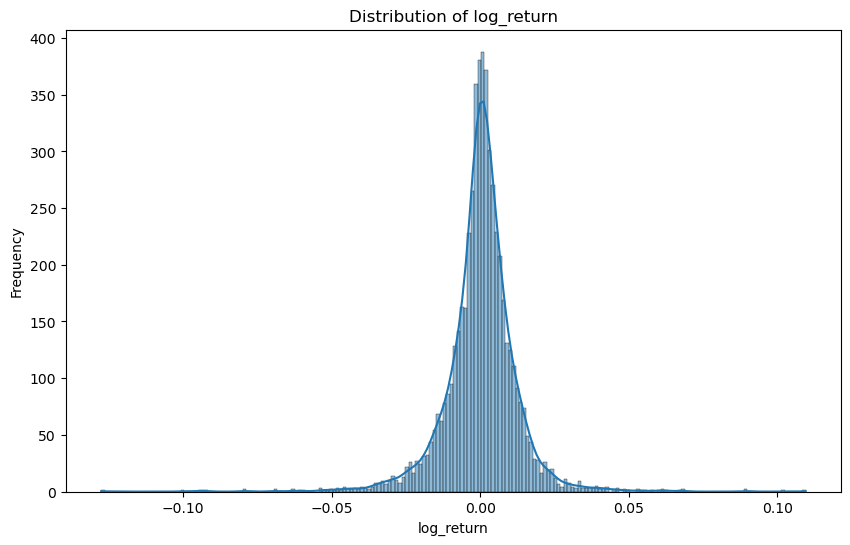

In [466]:
check_distribution(sp500_d, 'log_return')

C:\Users\Nagham\AppData\Local\Temp\ipykernel_14132\3138747750.py:17: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5517.



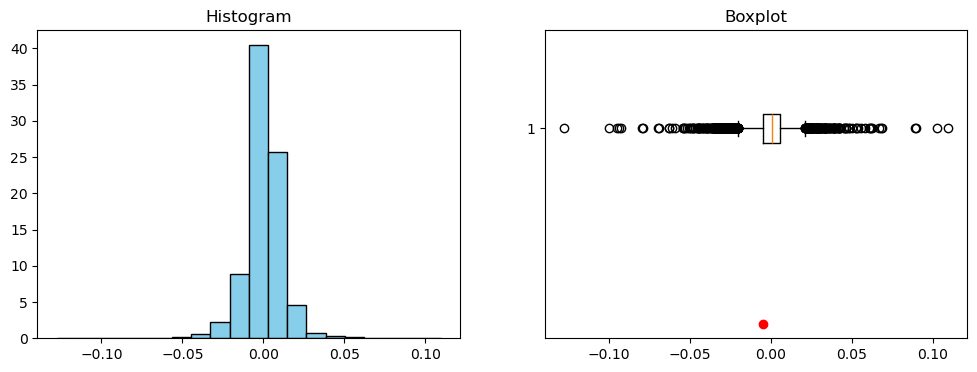

Summary Statistics:
Kurtosis: 11.5013
Skewness: -0.4227
Shapiro-Wilk test p-value: 0.0000


'Unknown'

In [ ]:
check_distribution_type(sp500_d['log_return'])

In [469]:
K = check_distribution_k(sp500_d['log_return'])
print(K)

Normally distributed


C:\Users\Nagham\AppData\Local\Temp\ipykernel_14132\3518033930.py:6: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5517.



In [74]:
#Split the data
sp500_d = truncate_before_wf(sp500_d, 200, 20)
splits = walk_forward_validation(sp500_d, 200, 20)

In [492]:
#Model - Linear SVR
#Linear_SVR = SVR(C=10000, kernel='linear')
Linear_SVR = LinearRegression()
#Linear_SVR = Lasso(alpha=1, fit_intercept=True, max_iter=500000)


In [359]:
#Arima model
# Fetch historical data for the S&P 500
data = yf.download('^GSPC', start='2002-01-01', end='2024-01-01')
data = calculate_log_return(data)
data = data.dropna()

[*********************100%%**********************]  1 of 1 completed


In [360]:
# Determine splitting point (e.g., use the last 20% of data for testing)
split_index = int(len(data) * 0.8)  # 80% training, 20% testing

# Split the data into training and testing sets
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

In [363]:
# Fit ARIMA model
model = ARIMA(train_data['log_return'], order=(200, 1, 0))  # Example order (p, d, q)
result = model.fit()

c:\Users\Nagham\MambaPython\envs\TechnionAiProg\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Nagham\MambaPython\envs\TechnionAiProg\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Nagham\MambaPython\envs\TechnionAiProg\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 4428
Model:               ARIMA(200, 1, 0)   Log Likelihood               13565.540
Date:                Mon, 08 Apr 2024   AIC                         -26729.080
Time:                        17:27:10   BIC                         -25443.589
Sample:                             0   HQIC                        -26275.747
                               - 4428                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0828      0.011    -96.078      0.000      -1.105      -1.061
ar.L2         -1.1197      0.016    -71.614      0.000      -1.150      -1.089
ar.L3         -1.0970      0.019    -56.860      0.0

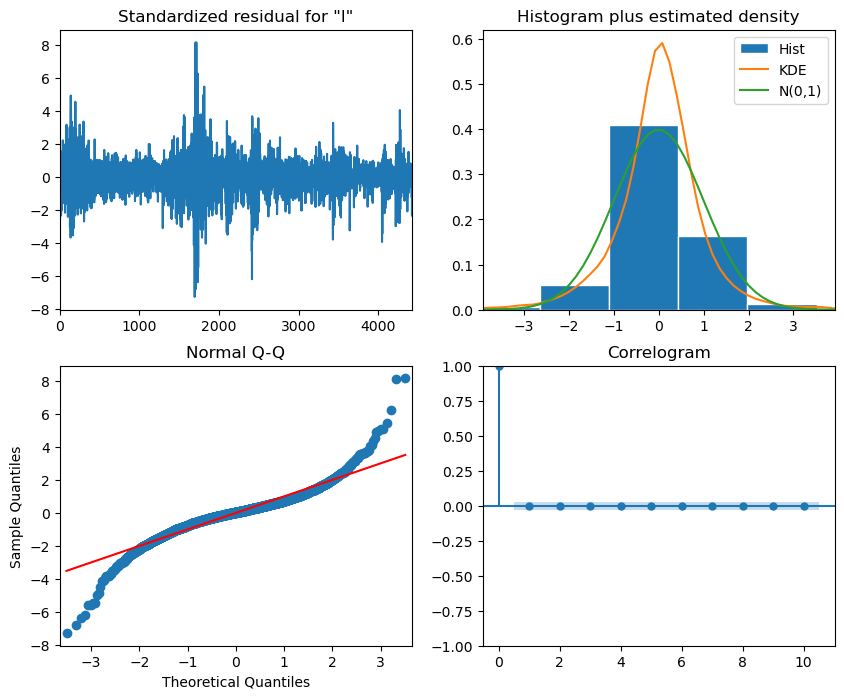

In [364]:
# Evaluate the model
print(result.summary())

# Plot diagnostic plots
result.plot_diagnostics(figsize=(10, 8))
plt.show()

c:\Users\Nagham\MambaPython\envs\TechnionAiProg\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\Nagham\MambaPython\envs\TechnionAiProg\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



Mean Squared Error: 0.00019884315522374622


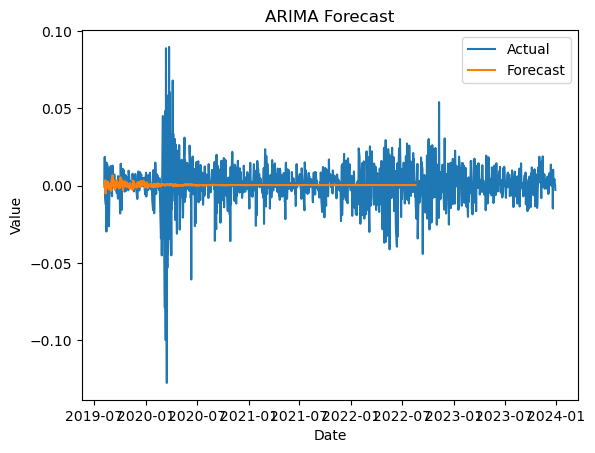

In [365]:
# Forecast future values
forecast = result.forecast(steps=len(test_data))

#index
forecast_index = pd.date_range(start='2019-08-07', periods=len(forecast))
forecast.index = forecast_index

# Evaluate model
actual_values = test_data['log_return']  # Actual values for last 20 time points
mse = mean_squared_error(actual_values, forecast)
print("Mean Squared Error:", mse)

# Plot results
plt.plot(test_data.index, test_data['log_return'], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Forecast')
plt.show()

[*********************100%%**********************]  1 of 1 completed


c:\Users\Nagham\MambaPython\envs\TechnionAiProg\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\Nagham\MambaPython\envs\TechnionAiProg\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



Mean Squared Error: 4.4885102695724084e-05


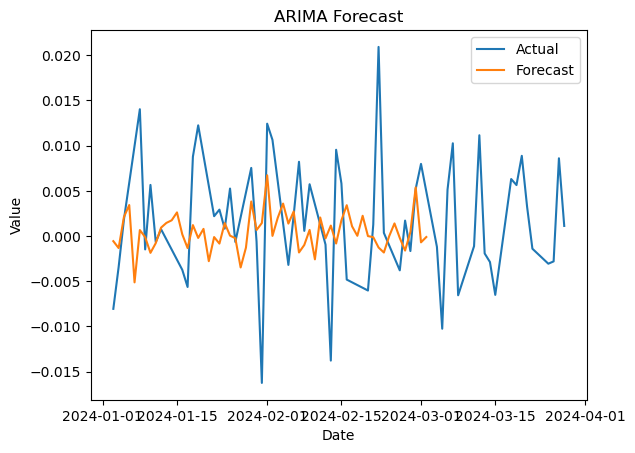

In [470]:
#test data
# Fetch historical data for the S&P 500
testdata = yf.download('^GSPC', start='2024-01-01', end='2024-04-01')
testdata = calculate_log_return(testdata)
testdata = drop_NAN(testdata)

# Forecast future values
forecast = result.forecast(steps=len(testdata))

#index
forecast_index = pd.date_range(start='2024-01-03', periods=len(forecast))
forecast.index = forecast_index

# Evaluate model
actual_values = testdata['log_return']  # Actual values for last 20 time points
mse = mean_squared_error(actual_values, forecast)
print("Mean Squared Error:", mse)

# Plot results
plt.plot(testdata.index, testdata['log_return'], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Forecast')
plt.show()

In [479]:
#train the model

# Initialize an empty list to store predictions
sp500_d['Predections_LinearSVM'] = np.nan

#Iterate over list of C params in order to find the best parameter
numParams = 4 #<! Number of different values of `C`
lC = np.linspace(10, 10000, numParams) #<! The list of `C` values to optimize over
dBestScore = {'Accuracy': 0, 'C': 0} #<! Dictionary to keep the highest score and the corresponding `C`
#train the model

# Initialize an empty list to store predictions
sp500_d['Predections_LinearSVM'] = np.nan

for ii, paramC in enumerate(lC):
    
    oSvrClassifier = SVR(C = paramC, kernel = 'linear') #<! Construct the SVC object
    #initiate the modelScore sum
    modelScore = 0

    # Loop through the splits and make predictions for each iteration
    for i, (in_sample, out_of_sample) in enumerate(splits):
        #Train the model on in_sample data
        X_train = in_sample.drop(columns=['log_return']) # dropping target variable
        y_train = in_sample['log_return']
        oSvrClassifier.fit(X_train,y_train)

        # Make predictions on the out-of-sample data
        X_test = out_of_sample.drop(columns=['log_return'])
        y_test = out_of_sample['log_return']
        predictions = oSvrClassifier.predict(X_test)
        
        # Out of Sample Index
        #oosI = out_of_sample.index # Adjusted index to match shifted returns

        #Add predictions to df
        #sp500_d.loc[oosI, 'Predections_LinearSVM']  = predictions
        modelScore     += oSvrClassifier.score(X_test, y_test) #<! Calculate the score (Accuracy)
    modelScore = modelScore/len(splits)
    print(modelScore)
    if (modelScore > dBestScore['Accuracy']):
        dBestScore['Accuracy'] = modelScore #<! Update the new best score
        dBestScore['C'] = paramC #<! Update the corresponding `C` hyper parameter

print(f'The best model has accuracy of {dBestScore["Accuracy"]:0.2%} with `C = {dBestScore["C"]}`')


-1.5608367999025734
-1.5608367999025734
-1.5608367999025734
-1.5608367999025734
The best model has accuracy of 0.00% with `C = 0`


In [480]:
# In the context of regression tasks like this one (since SVR is a Support Vector Machine for regression),
# where the target variable is continuous (e.g., log returns), a model score less than 0 typically indicates 
# that the model is performing poorly and making predictions that are worse than simply using the mean or another
# basic statistical measure as the prediction for all samples.

Model Score: 0.0
Mean Absolute Error: 0.009242746722188635
Mean Squared Error: 0.00020746505167476174
Root Mean Squared Error: 0.014403647165727219
R-squared: -0.4361777735805077


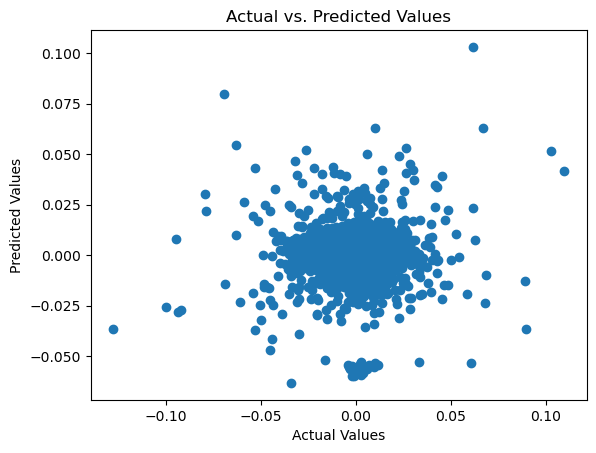

In [493]:
#train the model

# Initialize an empty list to store predictions
sp500_d['Predections_LinearSVM'] = np.nan

score = 0
# Loop through the splits and make predictions for each iteration
for i, (in_sample, out_of_sample) in enumerate(splits):
    #Train the model on in_sample data
    X_train = in_sample.drop(columns=['log_return']) # dropping target variable
    y_train = in_sample['log_return']
    Linear_SVR.fit(X_train,y_train)

    # Make predictions on the out-of-sample data
    X_test = out_of_sample.drop(columns=['log_return'])
    y_test = out_of_sample['log_return']
    predictions = Linear_SVR.predict(X_test)

    #model score
    #score += Linear_SVR.score(X_test, y_test)

    # Out of Sample Index
    oosI = out_of_sample.index # Adjusted index to match shifted returns

    #Add predictions to df
    sp500_d.loc[oosI, 'Predections_LinearSVM']  = predictions

sp500_d = drop_NAN(sp500_d)

# 4. Evaluation Metrics
score = score/len(splits)
mae = mean_absolute_error(sp500_d['log_return'], sp500_d['Predections_LinearSVM'])
mse = mean_squared_error(sp500_d['log_return'], sp500_d['Predections_LinearSVM'])
rmse = np.sqrt(mse)
r2 = r2_score(sp500_d['log_return'], sp500_d['Predections_LinearSVM'])

print("Model Score:", score)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

# Visualize predictions vs. actual values
plt.scatter(sp500_d['log_return'], sp500_d['Predections_LinearSVM'])
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

In [75]:
# Assuming df is your DataFrame containing the data
# Replace 'feature1' and 'feature2' with the names of the features you want to plot
feature1 = 'log_return'
feature2 = 'Predections_LinearSVM'

# Create line plot
fig = go.Figure(data=go.Scatter(
    x=sp500_d.index,  # Assuming the index represents x-axis values
    y=sp500_d[feature1],
    mode='lines',
    name=feature1
))

# Add another line plot for the second feature
fig.add_trace(go.Scatter(
    x=sp500_d.index,  # Assuming the index represents x-axis values
    y=sp500_d[feature2],
    mode='lines',
    name=feature2
))

# Customize layout
fig.update_layout(
    title='Linear SVR - log_return Vs. Predictions on train dataset - WF 200,20',
    xaxis=dict(title='X Axis'),  # Customize x-axis label
    yaxis=dict(title='Y Axis'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()


KeyError: 'Predections_LinearSVM'

In [ ]:
#rasha code
#clean the data from na values & pick the columns
scaled_df = sp500.copy()
scaled_df = drop_NAN(scaled_df)
scaled_df = scaled_df.loc[:, ['WMA_signal', 'macd_signal', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff', 'WPR', 'OBV', 'log_return']]

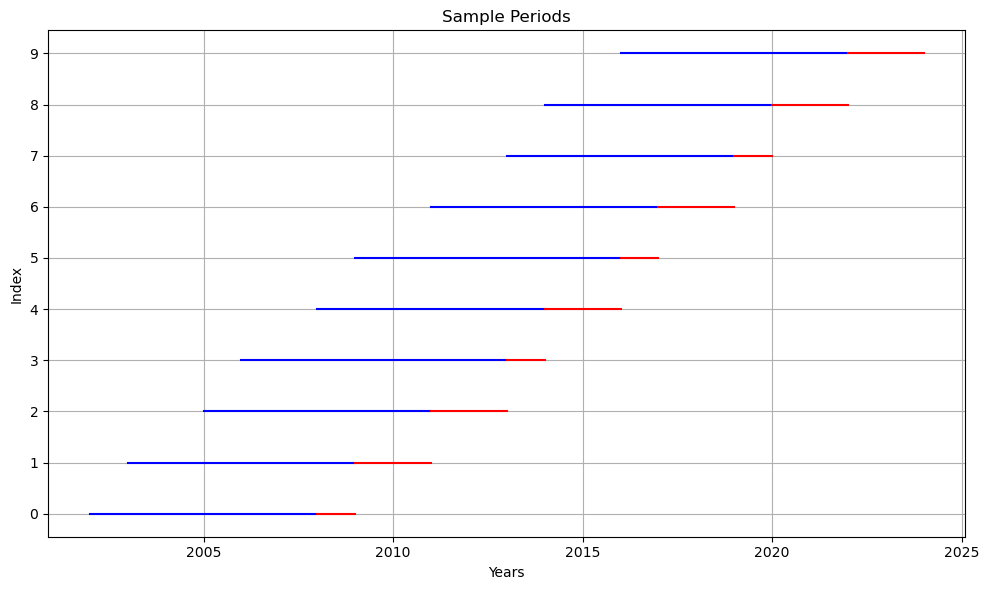

In [ ]:
groups = 10
train = np.array(scaled_df)
X, y = train[:, :-1], train[:, -1]

def build_rolling_calendar(start_date, end_date, out_of_sample_size, runs, n_gap):
    days = (end_date - start_date).days

    in_sample_size = (100 - out_of_sample_size) / 100
    out_of_sample_size = out_of_sample_size / 100

    total_days_per_run = round(days / (runs * out_of_sample_size + in_sample_size))
    in_sample_days_per_run = round(total_days_per_run * in_sample_size)
    out_of_sample_days_per_run = round(total_days_per_run * out_of_sample_size)

    calendar = pd.DataFrame()

    calendar['InSampleStarts'] = [start_date + timedelta(days=(out_of_sample_days_per_run * x))
                                  for x in range(runs)]
    calendar['InSampleEnds'] = [x + timedelta(days=in_sample_days_per_run)
                                for x in calendar['InSampleStarts']]

    calendar['OutSampleStarts'] = [start_date + timedelta(days=in_sample_days_per_run + n_gap) +
                                   timedelta(days=(out_of_sample_days_per_run * x))
                                   for x in range(runs)]
    calendar['OutSampleEnds'] = [x + timedelta(days=out_of_sample_days_per_run)
                                 for x in calendar['OutSampleStarts']]

    return calendar


calendar = build_rolling_calendar(start_date=scaled_df.index.min(), end_date=scaled_df.index.max(), out_of_sample_size=20, runs=10, n_gap=20)


# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for i, row in calendar.iterrows():
    ax.plot([row['InSampleStarts'].year, row['InSampleEnds'].year], [i, i], color='blue')
    ax.plot([row['OutSampleStarts'].year, row['OutSampleEnds'].year], [i, i], color='red')

# Customize plot
ax.set_yticks(calendar.index.values[::-1])
ax.set_yticklabels(calendar.index.values[::-1])
ax.set_xlabel('Years')
ax.set_ylabel('Index')
ax.set_title('Sample Periods')
ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from itertools import chain

X_train = []
X_test = []
y_train = []
y_test = []
for i, row in calendar.iterrows():
    train = scaled_df.loc[row['InSampleStarts']: row['InSampleEnds']].to_numpy()
    X_train.append(train[:, :-1])
    y_train.append(train[:, -1])
    test = scaled_df.loc[row['OutSampleStarts']: row['OutSampleEnds']].to_numpy()
    X_test.append(test[:, :-1])
    y_test.append(test[:,-1])
    if i == 0: 
        X_train_signals = scaled_df.loc[row['OutSampleStarts']:].to_numpy()


flattened_y_test = np.array(list(chain(*y_test)))

In [ ]:
svr_y_pred = []
svr = SVR(C=1, kernel='linear')
for i in range(len(X_train)):
    svr.fit(X_train[i], y_train[i])
    y_pred = svr.predict(X_test[i])
    svr_y_pred.extend(y_pred)
    #score = svr.score(y_pred, y_test[i])
    #print(f'batch {i} has a score of {score}')

# Assign the list of predictions to the DataFrame column
#sp500_d['Pred_log_return'].iloc[len((sp500_d)-200)] = np.concatenate(all_predictions)
#svr_score = svr.score(svr_y_pred,flattened_y_test)
#print(f'Accuracy of SVRegression is {svr_score}')


In [ ]:
scaled_df['predictions'] = np.zeros(scaled_df.shape[0])

# Determine the index range for appending predictions
start_index = scaled_df.shape[0] - 3934
end_index = scaled_df.shape[0]

# Assign predictions to the last 3934 indices of the DataFrame column
scaled_df['predictions'].iloc[start_index:end_index] = svr_y_pred

#scaled_df['predictions'] = svr_y_pred

C:\Users\Nagham\AppData\Local\Temp\ipykernel_16356\75687010.py:8: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [ ]:
scaled_df.head()

,WMA_signal,macd_signal,RSI,%K_fast,%D_fast,%D_slow,Bollinger Diff,WPR,OBV,log_return,predictions
Date,,,,,,,,,,,
2002-01-31,0.348314,-0.045964,-0.354627,-0.184620,-0.554774,-0.585866,-0.907893,-0.184620,-2.690000e+08,0.014824,0.0
2002-02-01,0.405828,-0.024413,-0.217141,0.248615,-0.493810,-0.555328,-0.908951,0.248615,1.288000e+09,-0.007104,0.0
2002-02-04,0.382644,-0.016735,-0.199933,0.207443,-0.251188,-0.451469,-0.913288,0.207443,-7.920000e+07,-0.025048,0.0
2002-02-05,0.303342,-0.038765,-0.307425,-0.619363,-0.089987,-0.294097,-0.910461,-0.619363,-1.516800e+09,-0.004047,0.0
2002-02-06,0.303483,-0.053770,-0.390146,-0.740896,-0.120292,-0.167627,-0.904818,-0.740896,-3.295100e+09,-0.005990,0.0


In [ ]:
# Assuming df is your DataFrame containing the data
# Replace 'feature1' and 'feature2' with the names of the features you want to plot
feature1 = 'log_return'
feature2 = 'predictions'

# Create line plot
fig = go.Figure(data=go.Scatter(
    x=scaled_df.index,  # Assuming the index represents x-axis values
    y=scaled_df[feature1],
    mode='lines',
    name=feature1
))

# Add another line plot for the second feature
fig.add_trace(go.Scatter(
    x=scaled_df.index,  # Assuming the index represents x-axis values
    y=scaled_df[feature2],
    mode='lines',
    name=feature2
))

# Customize layout
fig.update_layout(
    title='Linear SVR - log_return Vs. Predictions on train dataset - WF 200,20',
    xaxis=dict(title='X Axis'),  # Customize x-axis label
    yaxis=dict(title='Y Axis'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()


In [39]:
#KNN Model

In [40]:
#clean the data from na values & pick the columns
sp500_d = sp500.copy()
sp500_d = drop_NAN(sp500_d)
sp500_d = sp500_d.loc[:, ['WMA_signal', 'macd_signal', 'RSI', '%K_fast', '%D_fast', '%D_slow', 
                          'Bollinger Diff', 'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator',
                         'log_return']]

In [41]:
#Split the data
sp500_d = truncate_before_wf(sp500_d, 200, 20)
splits = walk_forward_validation(sp500_d, 200, 20)

In [42]:
class KNNRegressor:
    def __init__(self, k=5):
        self.k = k
        self.oKNNreg = KNeighborsRegressor(n_neighbors=k)

    def fit(self, dfX: pd.DataFrame, vY: pd.Series):
        self.oKNNreg.fit(dfX, vY) 

    def predict(self, dfX: pd.DataFrame):
        y_pred = self.oKNNreg.predict(dfX)
        return y_pred

    def score(self, dfX: pd.DataFrame, vY: pd.Series):
        R2 = self.oKNNreg.score(dfX, vY)
        return R2
    
    def train(self, splits, col_drop):
        predictions = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.oKNNreg.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            predictions.extend(self.oKNNreg.predict(X_test))

        return predictions
    
    def evaluate(self, y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)

        # Visualize predictions vs. actual values
        plt.scatter(y_true, y_pred)
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title("Actual vs. Predicted Values")
        plt.show()

        return {
            "Mean Absolute Error": mae,
            "Mean Squared Error": mse,
            "Root Mean Squared Error": rmse,
            "R-squared": r2
        }


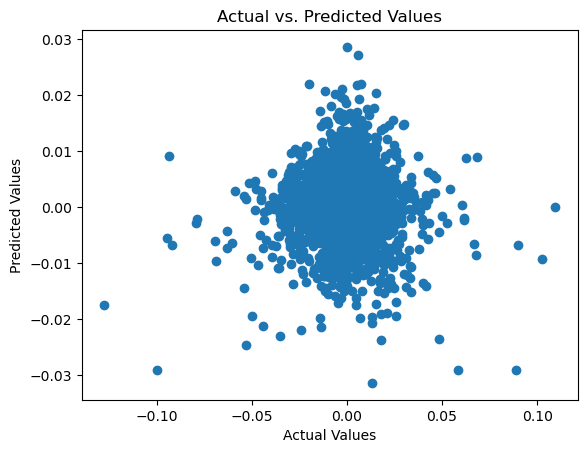

Mean Absolute Error: 0.008637742389379498
Mean Squared Error: 0.00016683073134740752
Root Mean Squared Error: 0.012916297122140211
R-squared: -0.15194358853386047


In [45]:
# Example usage:
# Instantiate LinearSVRTrainer
model = KNNRegressor()

# Train the model
predictions = model.train(splits,'log_return')

# Initialize an empty list to store predictions
index_dropped = len(sp500_d)-len(predictions)

sp500_d_includes_results = sp500_d.copy()
sp500_d_includes_results = sp500_d_includes_results.iloc[index_dropped:, :]
sp500_d_includes_results['Predections_LinearSVM'] = predictions

# Instantiate LinearSVREvaluator
evaluation_results = model.evaluate(sp500_d_includes_results['log_return'], sp500_d_includes_results['Predections_LinearSVM'] )

# Print evaluation results
for metric, value in evaluation_results.items():
    print(f"{metric}: {value}")

In [46]:
# Assuming df is your DataFrame containing the data
# Replace 'feature1' and 'feature2' with the names of the features you want to plot
feature1 = 'log_return'
feature2 = 'Predections_LinearSVM'

# Create line plot
fig = go.Figure(data=go.Scatter(
    x=sp500_d_includes_results.index,  # Assuming the index represents x-axis values
    y=sp500_d_includes_results[feature1],
    mode='lines',
    name=feature1
))

# Add another line plot for the second feature
fig.add_trace(go.Scatter(
    x=sp500_d_includes_results.index,  # Assuming the index represents x-axis values
    y=sp500_d_includes_results[feature2],
    mode='lines',
    name=feature2
))

# Customize layout
fig.update_layout(
    title='Linear SVR - log_return Vs. Predictions on train dataset - WF 200,20',
    xaxis=dict(title='X Axis'),  # Customize x-axis label
    yaxis=dict(title='Y Axis'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()


In [ ]:
#index from 30 Ap 2020 to 16 mar 2020
#sp500_d_includes_results.index['2020-04-30']
date_a_index = sp500_d_includes_results.index.get_loc('2020-04-30')
date_b_index = sp500_d_includes_results.index.get_loc('2020-03-16')

print(date_a_index - date_b_index)

32
